# Lab 5: RNNs, LSTMs and GRUs
## Authors
- Francisco Roh
- Bryan Calisto

## Sentiment analysis with Naive Bayes
### Instructions

Dataset
https://www.kaggle.com/c/sentiment-analysis-on-movie-reviews/data

Repeat the sentiment analysis exercise from Lab 2. For this one you will consider the following models:

    RNN
    LSTM
    GRU
    
Compare the results with each other and the Naive Bayes model obtained in Lab 2. The group with the best weighted F1 score gets 3 extra points to the final grade, the second best get 2 points, and the third gets 1 point. To simplify, consider only 3 categories: negative, neutral and positive.

## Carga de información

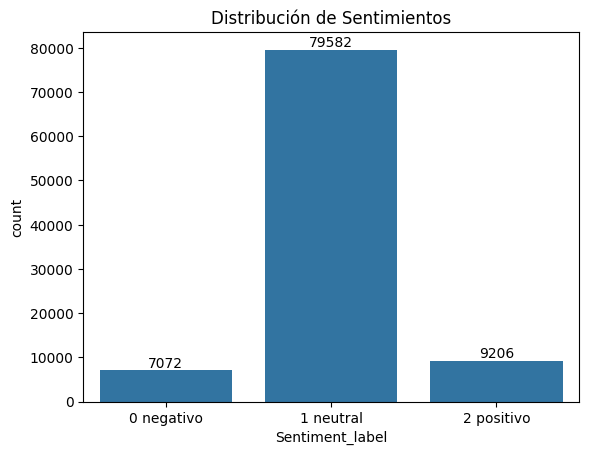

(95860, 5)


,PhraseId,SentenceId,Phrase,Sentiment,Sentiment_label
1,2,1,A series of escapades demonstrating the adage ...,1,1 neutral
2,3,1,A series,1,1 neutral
3,4,1,A,1,1 neutral
4,5,1,series,1,1 neutral
5,6,1,of escapades demonstrating the adage that what...,1,1 neutral


In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Cargar el archivo .tsv
df = pd.read_csv('train.tsv', sep='\t')

# Filtrar las categorías 0, 2, y 4
df = df[df['Sentiment'].isin([0, 2, 4])]

# Recategorizar a 0, 1, 2
df['Sentiment'] = df['Sentiment'].map({0: 0, 2: 1, 4: 2})

sentiment_labels = {
    0: '0 negativo',
    1: '1 neutral',
    2: '2 positivo'
}

# Añadir una columna con las etiquetas descriptivas
df['Sentiment_label'] = df['Sentiment'].map(sentiment_labels)

# Crear el gráfico de barras
ax = sns.countplot(x='Sentiment_label', data=df, order=['0 negativo', '1 neutral', '2 positivo'])

# Añadir etiquetas de los valores sobre cada barra usando `ax.bar_label`
ax.bar_label(ax.containers[0], label_type='edge')

plt.title('Distribución de Sentimientos')
plt.show()

# Mostrar la forma y primeras filas del DataFrame
print(df.shape)
df.head()

## Lab 2 Results: Naive Bayes models with variations.

### Tokenización

In [3]:
import spacy
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import nltk
import pandas as pd
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# Descargar recursos necesarios de nltk
nltk.download('stopwords')
nltk.download('wordnet')
# Cargar el modelo de idioma en inglés
nlp = spacy.load('en_core_web_sm')

# Función para tokenizar usando spaCy
def tokenize_phrase_spacy(phrase):
    doc = nlp(phrase)
    return [token.text for token in doc]

# Aplicar la tokenización a la columna 'Phrase' del DataFrame
df['Phrase_Tokens'] = df['Phrase'].apply(tokenize_phrase_spacy)

# Mostrar las primeras filas para verificar
df[['Phrase', 'Phrase_Tokens']].head()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Francisco\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Francisco\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

### Preprocesamiento y modelado

In [4]:
# Preprocesamiento
df['lower_text'] = df['Phrase'].str.lower()

No_Stopwords = df.copy()

No_Stopwords['Phrase_No_Stopwords'] = No_Stopwords['lower_text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stopwords.words('english'))]))

No_Stopwords = No_Stopwords[~No_Stopwords['Phrase_No_Stopwords'].str.fullmatch(r'\s*')]
No_Stopwords = No_Stopwords.drop_duplicates(subset=['Phrase_No_Stopwords', 'Sentiment'])
No_Stopwords = No_Stopwords.dropna(subset=['Phrase_No_Stopwords'])

df['Phrase_Stemmed'] = df['Phrase'].apply(lambda x: ' '.join([PorterStemmer().stem(word) for word in x.split()]))
No_Stopwords['Phrase_Stemmed'] = No_Stopwords['Phrase_No_Stopwords'].apply(lambda x: ' '.join([PorterStemmer().stem(word) for word in x.split()]))

df['Phrase_Lemmatized'] = df['Phrase'].apply(lambda x: ' '.join([WordNetLemmatizer().lemmatize(word) for word in x.split()]))
No_Stopwords['Phrase_Lemmatized'] = No_Stopwords['Phrase_No_Stopwords'].apply(lambda x: ' '.join([WordNetLemmatizer().lemmatize(word) for word in x.split()]))



#Función de entrenamiento y evaluación Naive Bayes
def train_and_evaluate_model_nb(tipo_data, X, y, average='weighted'):
    # Dividir los datos en conjuntos de entrenamiento y prueba
    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

    # Crear el modelo de Naive Bayes
    model = MultinomialNB()

    # Entrenar el modelo con los datos de entrenamiento
    model.fit(X_train, y_train)

    # Predecir las clases en el conjunto de prueba
    y_pred = model.predict(X_test)


    # Mostrar el informe de clasificación
    cr = classification_report(y_test, y_pred, target_names=['0 Negativo', '1 Neutral', '2 Positivo'])
    print(cr)

    # Calcular la matriz de confusión
    cm = confusion_matrix(y_test, y_pred)

    # Definir las etiquetas de las clases
    class_names = ['0 Negativo', '1 Neutral', '2 Positivo']

    # Crear el mapa de calor de la matriz de confusión
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average=average)
    recall = recall_score(y_test, y_pred, average=average)
    f1 = f1_score(y_test, y_pred, average=average)

    print(f"Accuracy: {accuracy}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1-Score: {f1}")

    metricas = {
        'Data': tipo_data,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'Classification Report': cr,
        'Matriz de Confusión': cm,
        'Train Registros': len(y_train),
        'Test Registros': len(y_test)
    }

    return metricas


### Evaluación Naive Bayes


Procesando Frases originales...


Entrenando y evaluando el modelo para Frases originales - BoW Binario...

              precision    recall  f1-score   support

  0 Negativo       0.66      0.52      0.58      1415
   1 Neutral       0.92      0.95      0.93     15916
  2 Positivo       0.72      0.63      0.67      1841

    accuracy                           0.89     19172
   macro avg       0.76      0.70      0.73     19172
weighted avg       0.88      0.89      0.88     19172



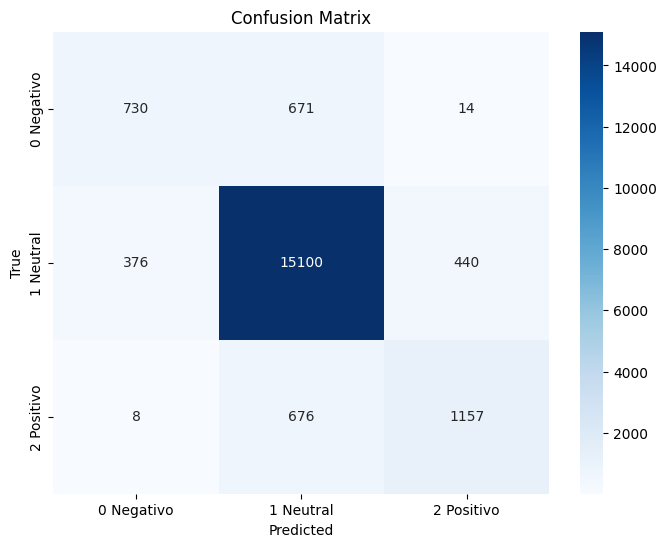

Accuracy: 0.8860317129146672
Precision: 0.8795074004272982
Recall: 0.8860317129146672
F1-Score: 0.8816616751359091

Entrenando y evaluando el modelo para Frases originales - BoW Frecuencia...

              precision    recall  f1-score   support

  0 Negativo       0.66      0.52      0.58      1415
   1 Neutral       0.92      0.95      0.93     15916
  2 Positivo       0.72      0.63      0.67      1841

    accuracy                           0.89     19172
   macro avg       0.76      0.70      0.73     19172
weighted avg       0.88      0.89      0.88     19172



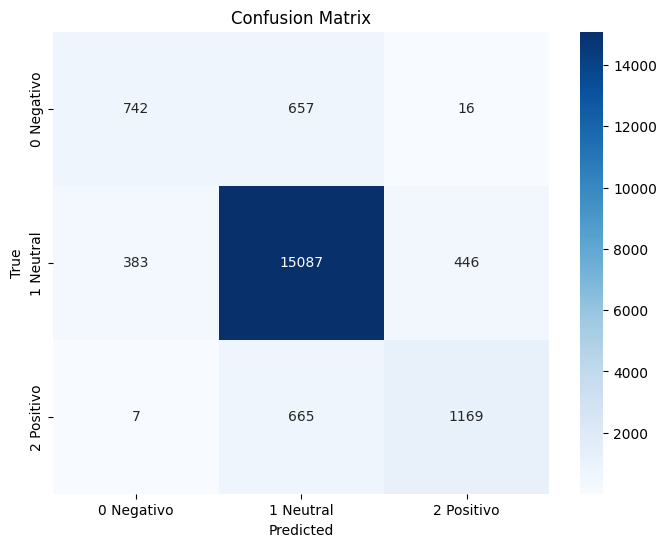

Accuracy: 0.8866054663050281
Precision: 0.8804889335648778
Recall: 0.8866054663050281
F1-Score: 0.8825919528600138

Entrenando y evaluando el modelo para Frases originales - BoW TF_IDF...

              precision    recall  f1-score   support

  0 Negativo       0.81      0.12      0.21      1415
   1 Neutral       0.86      0.99      0.92     15916
  2 Positivo       0.87      0.25      0.39      1841

    accuracy                           0.86     19172
   macro avg       0.85      0.45      0.51     19172
weighted avg       0.86      0.86      0.82     19172



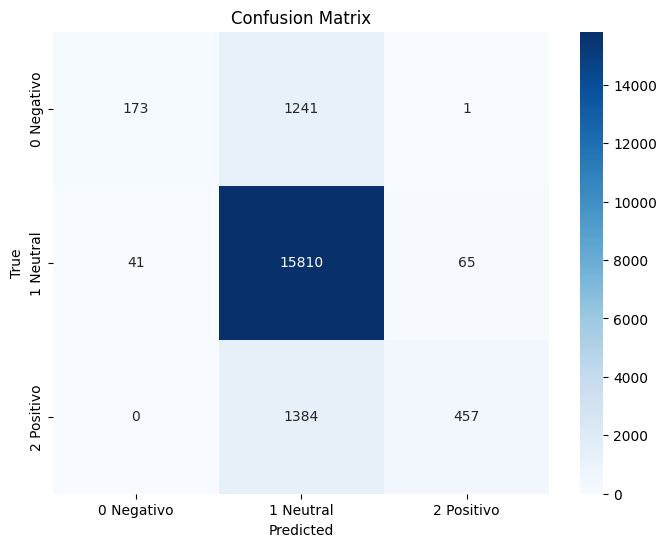

Accuracy: 0.8575005215939913
Precision: 0.855532169041977
Recall: 0.8575005215939913
F1-Score: 0.8169711626938271

Procesando Frases originales en minúsculas...


Entrenando y evaluando el modelo para Frases originales en minúsculas - BoW Binario...

              precision    recall  f1-score   support

  0 Negativo       0.66      0.52      0.58      1415
   1 Neutral       0.92      0.95      0.93     15916
  2 Positivo       0.72      0.63      0.67      1841

    accuracy                           0.89     19172
   macro avg       0.76      0.70      0.73     19172
weighted avg       0.88      0.89      0.88     19172



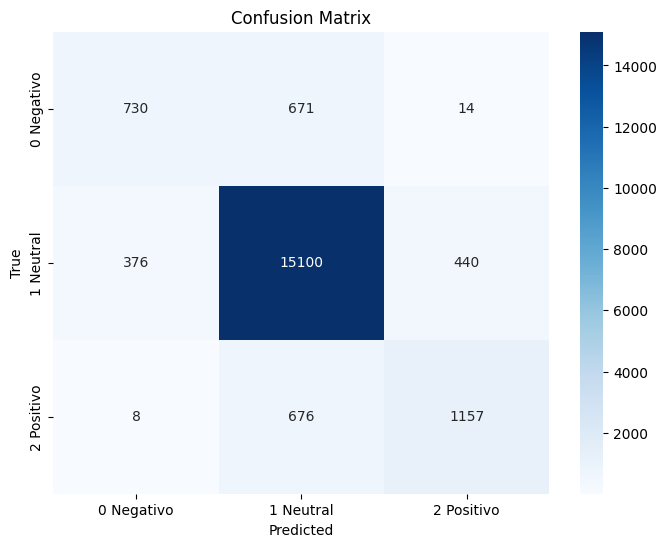

Accuracy: 0.8860317129146672
Precision: 0.8795074004272982
Recall: 0.8860317129146672
F1-Score: 0.8816616751359091

Entrenando y evaluando el modelo para Frases originales en minúsculas - BoW Frecuencia...

              precision    recall  f1-score   support

  0 Negativo       0.66      0.52      0.58      1415
   1 Neutral       0.92      0.95      0.93     15916
  2 Positivo       0.72      0.63      0.67      1841

    accuracy                           0.89     19172
   macro avg       0.76      0.70      0.73     19172
weighted avg       0.88      0.89      0.88     19172



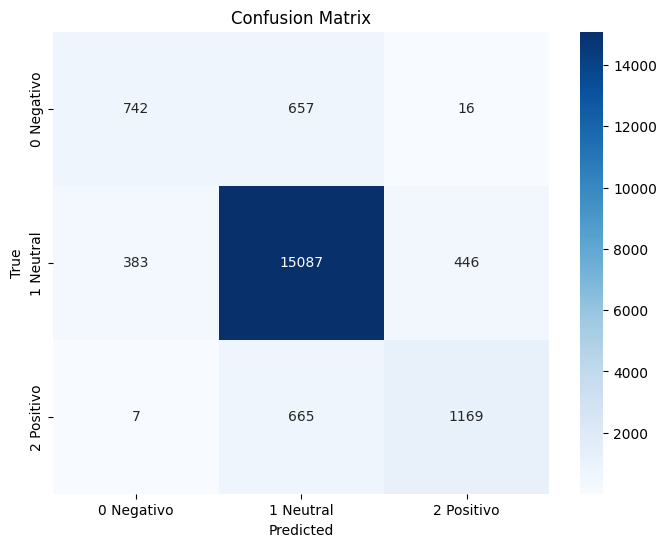

Accuracy: 0.8866054663050281
Precision: 0.8804889335648778
Recall: 0.8866054663050281
F1-Score: 0.8825919528600138

Entrenando y evaluando el modelo para Frases originales en minúsculas - BoW TF_IDF...

              precision    recall  f1-score   support

  0 Negativo       0.81      0.12      0.21      1415
   1 Neutral       0.86      0.99      0.92     15916
  2 Positivo       0.87      0.25      0.39      1841

    accuracy                           0.86     19172
   macro avg       0.85      0.45      0.51     19172
weighted avg       0.86      0.86      0.82     19172



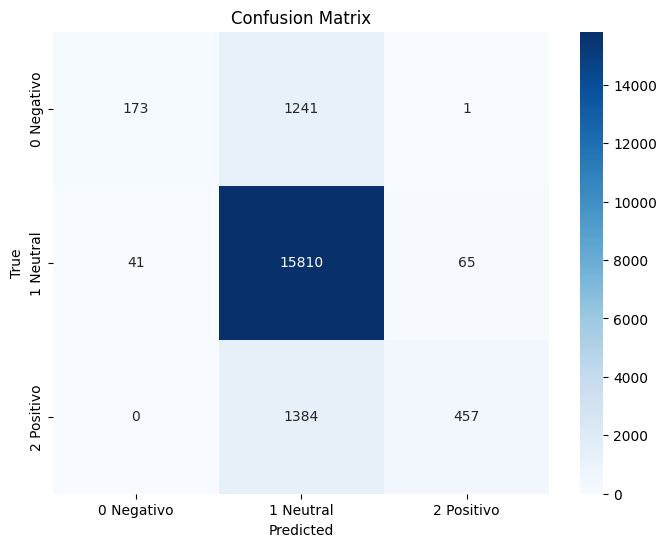

Accuracy: 0.8575005215939913
Precision: 0.855532169041977
Recall: 0.8575005215939913
F1-Score: 0.8169711626938271

Procesando Frases originales con stemming...


Entrenando y evaluando el modelo para Frases originales con stemming - BoW Binario...

              precision    recall  f1-score   support

  0 Negativo       0.67      0.50      0.57      1415
   1 Neutral       0.91      0.96      0.93     15916
  2 Positivo       0.74      0.59      0.66      1841

    accuracy                           0.89     19172
   macro avg       0.78      0.68      0.72     19172
weighted avg       0.88      0.89      0.88     19172



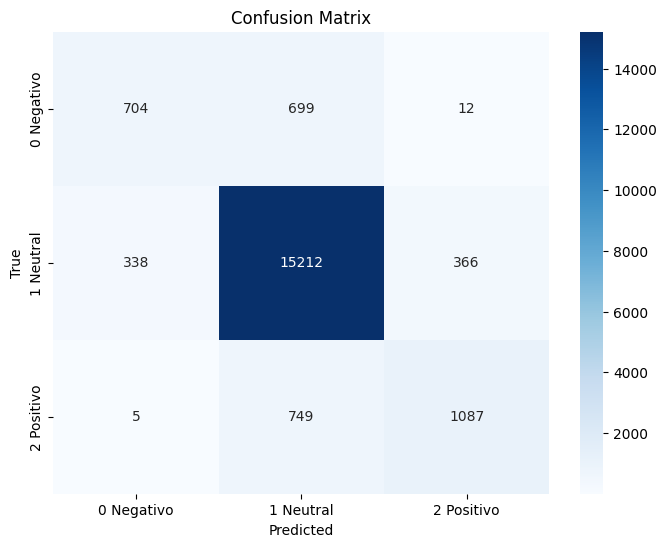

Accuracy: 0.8868662633006468
Precision: 0.8788906270618848
Recall: 0.8868662633006468
F1-Score: 0.880681737435357

Entrenando y evaluando el modelo para Frases originales con stemming - BoW Frecuencia...

              precision    recall  f1-score   support

  0 Negativo       0.67      0.51      0.58      1415
   1 Neutral       0.91      0.95      0.93     15916
  2 Positivo       0.74      0.60      0.66      1841

    accuracy                           0.89     19172
   macro avg       0.77      0.69      0.72     19172
weighted avg       0.88      0.89      0.88     19172



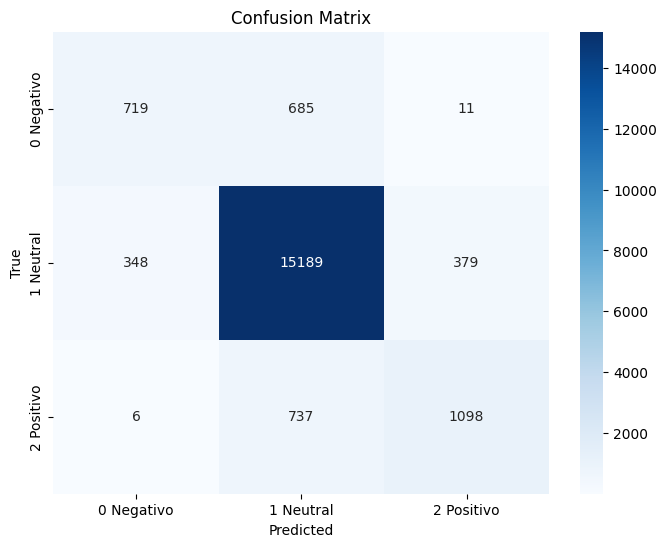

Accuracy: 0.887022741498018
Precision: 0.8794150136484387
Recall: 0.887022741498018
F1-Score: 0.8813228591469228

Entrenando y evaluando el modelo para Frases originales con stemming - BoW TF_IDF...

              precision    recall  f1-score   support

  0 Negativo       0.79      0.12      0.21      1415
   1 Neutral       0.85      0.99      0.92     15916
  2 Positivo       0.86      0.21      0.34      1841

    accuracy                           0.85     19172
   macro avg       0.84      0.44      0.49     19172
weighted avg       0.85      0.85      0.81     19172



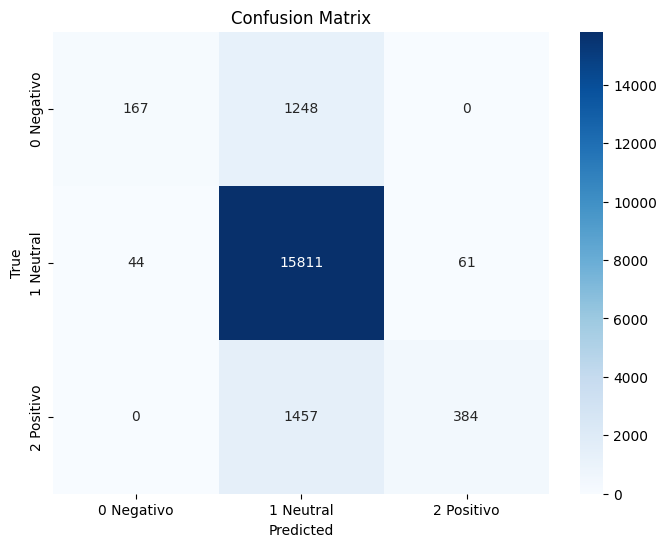

Accuracy: 0.8534320884623409
Precision: 0.8501669502178804
Recall: 0.8534320884623409
F1-Score: 0.8098398661271431

Procesando Frases originales con lemmatization...


Entrenando y evaluando el modelo para Frases originales con lemmatization - BoW Binario...

              precision    recall  f1-score   support

  0 Negativo       0.66      0.51      0.57      1415
   1 Neutral       0.92      0.95      0.93     15916
  2 Positivo       0.72      0.61      0.66      1841

    accuracy                           0.89     19172
   macro avg       0.77      0.69      0.72     19172
weighted avg       0.88      0.89      0.88     19172



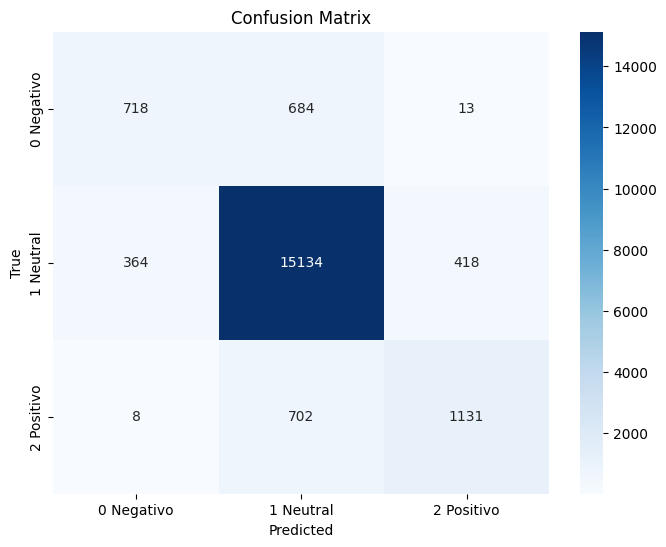

Accuracy: 0.8858230753181723
Precision: 0.8786654052889717
Recall: 0.8858230753181723
F1-Score: 0.8808192091211678

Entrenando y evaluando el modelo para Frases originales con lemmatization - BoW Frecuencia...

              precision    recall  f1-score   support

  0 Negativo       0.65      0.52      0.58      1415
   1 Neutral       0.92      0.95      0.93     15916
  2 Positivo       0.72      0.61      0.66      1841

    accuracy                           0.89     19172
   macro avg       0.76      0.69      0.72     19172
weighted avg       0.88      0.89      0.88     19172



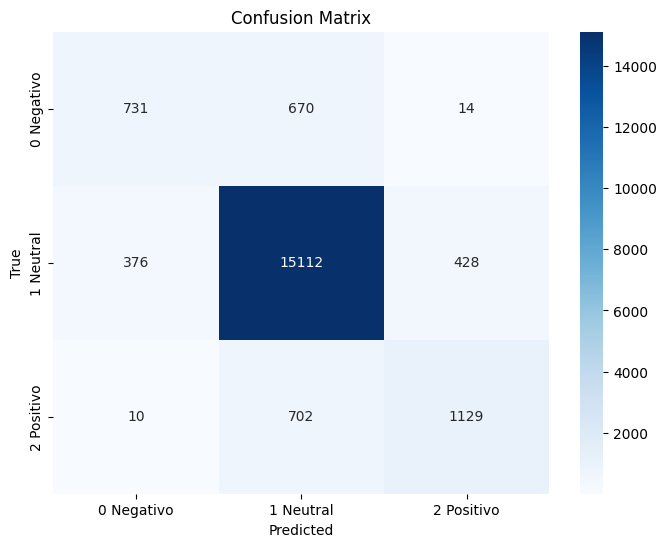

Accuracy: 0.8852493219278114
Precision: 0.8783816055111888
Recall: 0.8852493219278114
F1-Score: 0.8805783490617355

Entrenando y evaluando el modelo para Frases originales con lemmatization - BoW TF_IDF...

              precision    recall  f1-score   support

  0 Negativo       0.81      0.12      0.22      1415
   1 Neutral       0.86      0.99      0.92     15916
  2 Positivo       0.88      0.25      0.39      1841

    accuracy                           0.86     19172
   macro avg       0.85      0.46      0.51     19172
weighted avg       0.86      0.86      0.82     19172



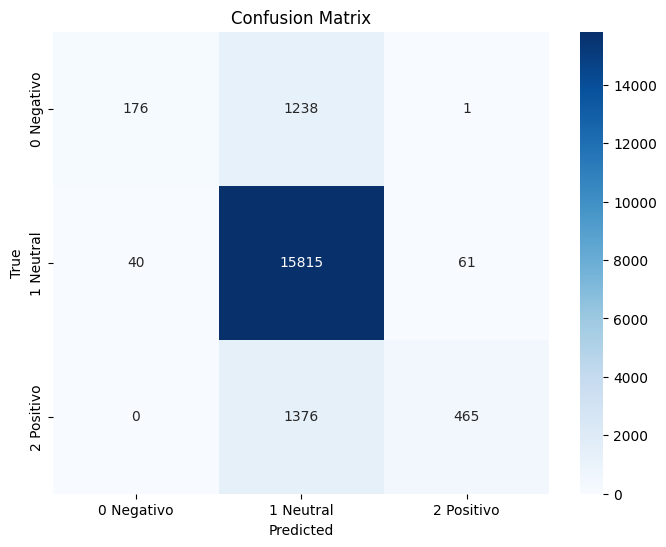

Accuracy: 0.8583350719799708
Precision: 0.857282642696385
Recall: 0.8583350719799708
F1-Score: 0.8181847700989106

Procesando Frases sin stop words...


Entrenando y evaluando el modelo para Frases sin stop words - BoW Binario...

              precision    recall  f1-score   support

  0 Negativo       0.65      0.48      0.55      1243
   1 Neutral       0.89      0.94      0.91     11240
  2 Positivo       0.70      0.59      0.64      1603

    accuracy                           0.86     14086
   macro avg       0.75      0.67      0.70     14086
weighted avg       0.85      0.86      0.85     14086



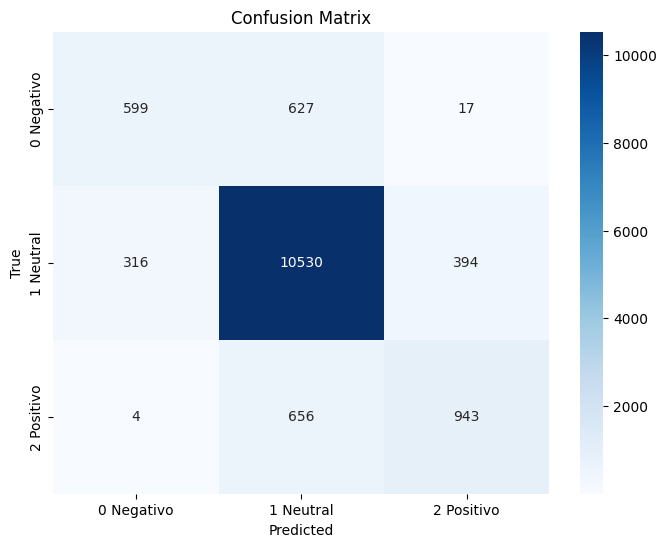

Accuracy: 0.8570211557574897
Precision: 0.8480641807272238
Recall: 0.8570211557574897
F1-Score: 0.8504502927662168

Entrenando y evaluando el modelo para Frases sin stop words - BoW Frecuencia...

              precision    recall  f1-score   support

  0 Negativo       0.65      0.49      0.56      1243
   1 Neutral       0.89      0.94      0.91     11240
  2 Positivo       0.70      0.59      0.64      1603

    accuracy                           0.86     14086
   macro avg       0.75      0.67      0.70     14086
weighted avg       0.85      0.86      0.85     14086



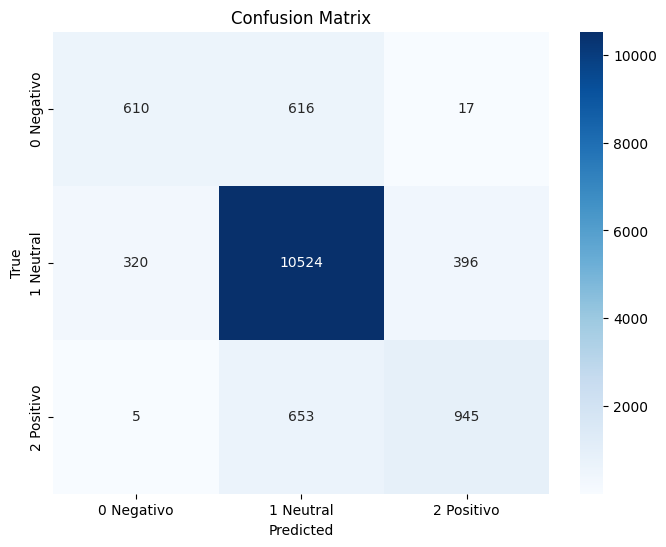

Accuracy: 0.8575181030810735
Precision: 0.8488525557080114
Recall: 0.8575181030810735
F1-Score: 0.8512553654988531

Entrenando y evaluando el modelo para Frases sin stop words - BoW TF_IDF...

              precision    recall  f1-score   support

  0 Negativo       0.80      0.11      0.20      1243
   1 Neutral       0.83      0.99      0.90     11240
  2 Positivo       0.89      0.25      0.39      1603

    accuracy                           0.83     14086
   macro avg       0.84      0.45      0.50     14086
weighted avg       0.83      0.83      0.78     14086



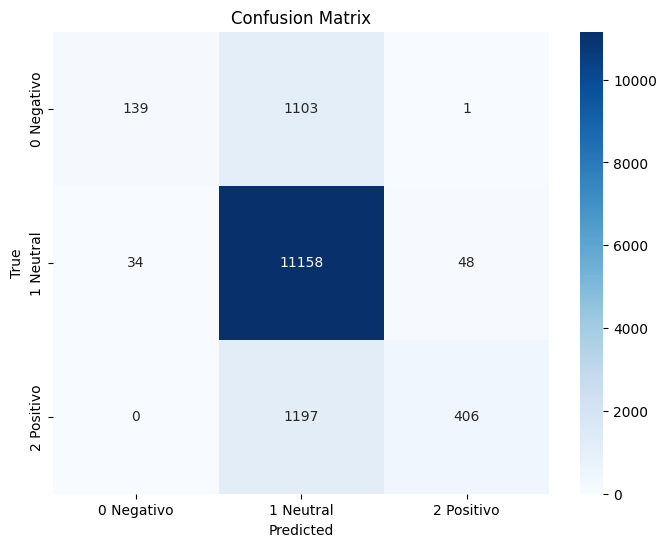

Accuracy: 0.830824932557149
Precision: 0.8340296035155033
Recall: 0.830824932557149
F1-Score: 0.7832222823104514

Procesando Frases sin stop words con stemming...


Entrenando y evaluando el modelo para Frases sin stop words con stemming - BoW Binario...

              precision    recall  f1-score   support

  0 Negativo       0.66      0.44      0.53      1243
   1 Neutral       0.88      0.95      0.91     11240
  2 Positivo       0.71      0.55      0.62      1603

    accuracy                           0.86     14086
   macro avg       0.75      0.64      0.69     14086
weighted avg       0.85      0.86      0.85     14086



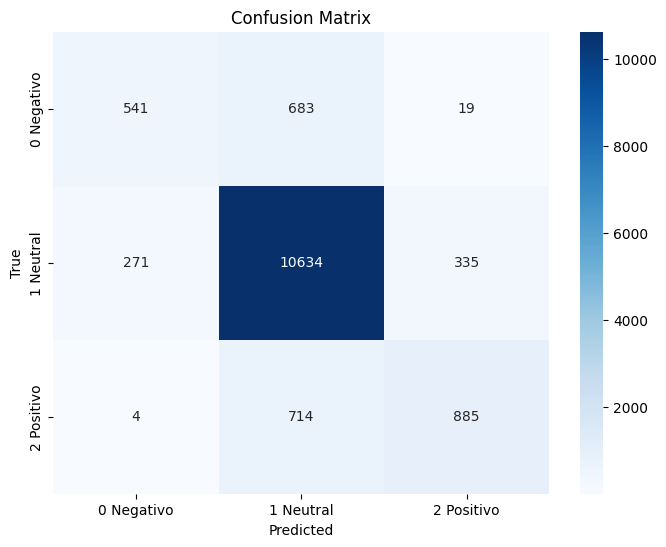

Accuracy: 0.8561692460599176
Precision: 0.8450905240850328
Recall: 0.8561692460599176
F1-Score: 0.8465203270833146

Entrenando y evaluando el modelo para Frases sin stop words con stemming - BoW Frecuencia...

              precision    recall  f1-score   support

  0 Negativo       0.67      0.44      0.53      1243
   1 Neutral       0.88      0.95      0.91     11240
  2 Positivo       0.71      0.55      0.62      1603

    accuracy                           0.86     14086
   macro avg       0.75      0.65      0.69     14086
weighted avg       0.85      0.86      0.85     14086



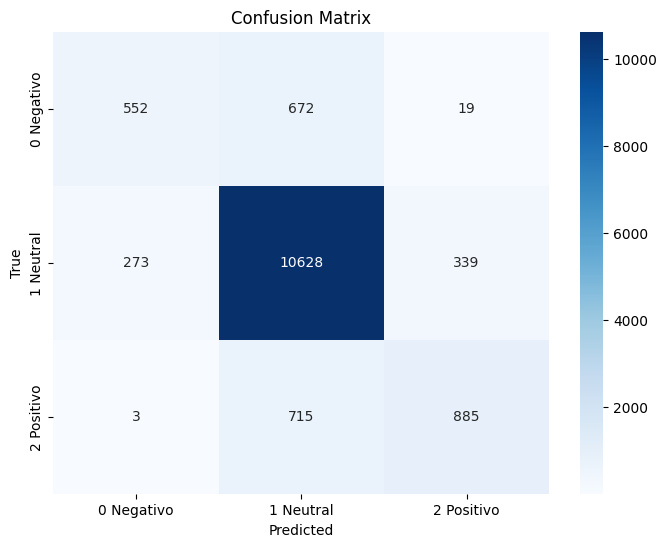

Accuracy: 0.856524208433906
Precision: 0.845694113622403
Recall: 0.856524208433906
F1-Score: 0.8471794210821947

Entrenando y evaluando el modelo para Frases sin stop words con stemming - BoW TF_IDF...

              precision    recall  f1-score   support

  0 Negativo       0.80      0.10      0.19      1243
   1 Neutral       0.82      0.99      0.90     11240
  2 Positivo       0.85      0.21      0.33      1603

    accuracy                           0.82     14086
   macro avg       0.82      0.43      0.47     14086
weighted avg       0.82      0.82      0.77     14086



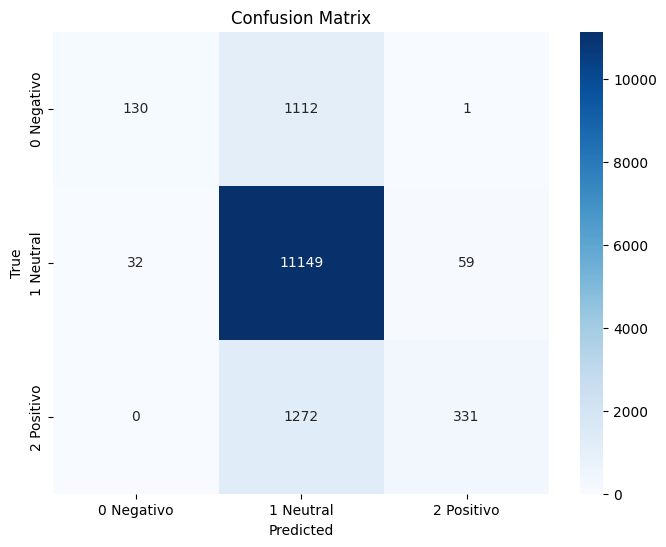

Accuracy: 0.8242226324009655
Precision: 0.8245366951899459
Recall: 0.8242226324009655
F1-Score: 0.7723451992405991

Procesando Frases sin stop words con lemmatization...


Entrenando y evaluando el modelo para Frases sin stop words con lemmatization - BoW Binario...

              precision    recall  f1-score   support

  0 Negativo       0.66      0.47      0.55      1243
   1 Neutral       0.89      0.94      0.91     11240
  2 Positivo       0.70      0.58      0.64      1603

    accuracy                           0.86     14086
   macro avg       0.75      0.66      0.70     14086
weighted avg       0.85      0.86      0.85     14086



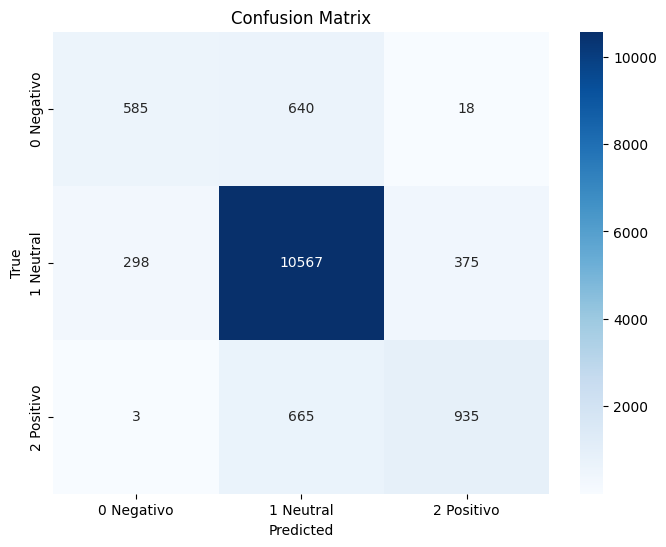

Accuracy: 0.8580860428794548
Precision: 0.848630267743807
Recall: 0.8580860428794548
F1-Score: 0.8507642828332204

Entrenando y evaluando el modelo para Frases sin stop words con lemmatization - BoW Frecuencia...

              precision    recall  f1-score   support

  0 Negativo       0.66      0.48      0.56      1243
   1 Neutral       0.89      0.94      0.91     11240
  2 Positivo       0.70      0.58      0.64      1603

    accuracy                           0.86     14086
   macro avg       0.75      0.67      0.70     14086
weighted avg       0.85      0.86      0.85     14086



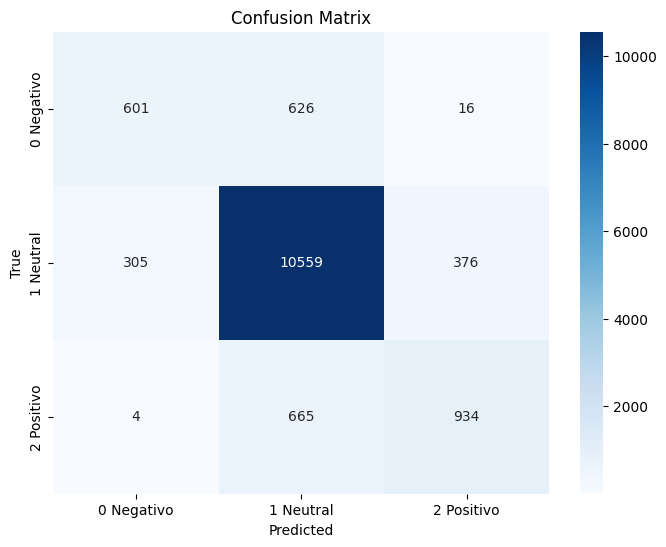

Accuracy: 0.8585829902030385
Precision: 0.8494600686914013
Recall: 0.8585829902030385
F1-Score: 0.8516494194445097

Entrenando y evaluando el modelo para Frases sin stop words con lemmatization - BoW TF_IDF...

              precision    recall  f1-score   support

  0 Negativo       0.83      0.11      0.20      1243
   1 Neutral       0.83      0.99      0.90     11240
  2 Positivo       0.88      0.25      0.39      1603

    accuracy                           0.83     14086
   macro avg       0.84      0.45      0.50     14086
weighted avg       0.83      0.83      0.78     14086



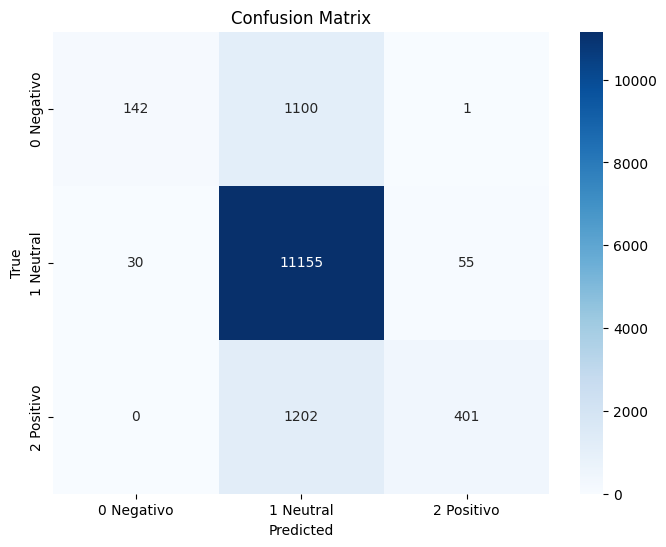

Accuracy: 0.8304699701831606
Precision: 0.8341627374385434
Recall: 0.8304699701831606
F1-Score: 0.7828480137334618


In [5]:
# Definir las columnas y sus respectivos tipo_data
columns_to_process = {
    'Frases originales': ('df', 'Phrase'),
    'Frases originales en minúsculas': ('df', 'lower_text'),
    'Frases originales con stemming': ('df', 'Phrase_Stemmed'),
    'Frases originales con lemmatization': ('df', 'Phrase_Lemmatized'),
    'Frases sin stop words': ('No_Stopwords', 'Phrase_No_Stopwords'),
    'Frases sin stop words con stemming': ('No_Stopwords', 'Phrase_Stemmed'),
    'Frases sin stop words con lemmatization': ('No_Stopwords', 'Phrase_Lemmatized')
}

# Diccionarios para almacenar los resultados
binary_vectors = {}
frequency_vectors = {}
TF_IDF_vectors = {}
resultados = []

# Iterar sobre las columnas y aplicar CountVectorizer
for tipo_data, (dataframe, column) in columns_to_process.items():
    print(f"\nProcesando {tipo_data}...\n")

    # Crear el vectorizador binario (Bag of Words binario)
    vectorizer_binary = CountVectorizer(binary=True)
    if dataframe == 'df':
        X_binary = vectorizer_binary.fit_transform(df[column])
        y = df['Sentiment']
    else:
        X_binary = vectorizer_binary.fit_transform(No_Stopwords[column])
        y = No_Stopwords['Sentiment']

    # Guardar los resultados en el diccionario utilizando tipo_data como clave
    binary_vectors[tipo_data] = (X_binary, y)

    # Entrenar y evaluar el modelo
    print(f"\nEntrenando y evaluando el modelo para {tipo_data} - BoW Binario...\n")
    metricas = train_and_evaluate_model_nb('Naive Bayes '+tipo_data + ' - BoW Binario', X_binary, y)
    resultados.append(metricas)

    # Crear el vectorizador basado en frecuencia (Bag of Words de frecuencias)
    vectorizer_frequency = CountVectorizer(binary=False)
    if dataframe == 'df':
        X_frequency = vectorizer_frequency.fit_transform(df[column])
        y = df['Sentiment']
    else:
        X_frequency = vectorizer_frequency.fit_transform(No_Stopwords[column])
        y = No_Stopwords['Sentiment']

    # Guardar los resultados en el diccionario utilizando tipo_data como clave
    frequency_vectors[tipo_data] = (X_frequency, y)

    # Entrenar y evaluar el modelo
    print(f"\nEntrenando y evaluando el modelo para {tipo_data} - BoW Frecuencia...\n")
    metricas = train_and_evaluate_model_nb('Naive Bayes '+ tipo_data + ' - BoW Frecuencia', X_frequency, y)
    resultados.append(metricas)

    # Crear el vectorizador basado en TF_IDF
    vectorizer_TF_IDF = TfidfVectorizer()
    if dataframe == 'df':
        X_TF_IDF = vectorizer_TF_IDF.fit_transform(df[column])
        y = df['Sentiment']
    else:
        X_TF_IDF = vectorizer_TF_IDF.fit_transform(No_Stopwords[column])
        y = No_Stopwords['Sentiment']

    # Guardar los resultados en el diccionario utilizando tipo_data como clave
    TF_IDF_vectors[tipo_data] = (X_TF_IDF, y)

    # Entrenar y evaluar el modelo
    print(f"\nEntrenando y evaluando el modelo para {tipo_data} - BoW TF_IDF...\n")
    metricas = train_and_evaluate_model_nb('Naive Bayes '+ tipo_data + ' - Bow TF_IDF', X_TF_IDF, y)
    resultados.append(metricas)

## RNN, GRU y LSTM 

In [6]:
%pip install lightning
%pip install torchtext


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.3.2 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.3.2 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [7]:
import pandas as pd
from torch.utils.data import Dataset, DataLoader
import pytorch_lightning as pl
from torchtext.vocab import build_vocab_from_iterator
from torch.nn.utils.rnn import pad_sequence
import torch
import torch.nn as nn
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize
import torchtext
import re
torchtext.disable_torchtext_deprecation_warning()

class TextDataset(Dataset):
    def __init__(self, dataframe, column):
        self.dataframe = dataframe.drop_duplicates()
        self.column = column

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        texto = self.dataframe.iloc[idx][self.column]
        label = self.dataframe.iloc[idx]['Sentiment']
        return texto, label

c:\Users\Francisco\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: 'Could not find module 'C:\Users\Francisco\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\image.pyd' (or one of its dependencies). Try using the full path with constructor syntax.'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


OSError: [WinError 127] No se encontró el proceso especificado

In [ ]:
class PreguntaDataModule(pl.LightningDataModule):
    def __init__(self, dataframe, column, batch_size=32, embedding_dim=512):
        super().__init__()
        self.dataframe = dataframe
        self.column = column
        self.batch_size = batch_size
        self.embedding_dim = embedding_dim
        self.num_workers = NUM_WORKERS

        self.text_tokenizer = word_tokenize
        self.vocab = self.build_vocab(self.dataframe[self.column])
        self.vocab_size = len(self.vocab)

    def build_vocab(self, texts):
        token_generator = (self.text_tokenizer(text) for text in texts)
        vocab = build_vocab_from_iterator(token_generator, specials=["<unk>"])
        vocab.set_default_index(vocab["<unk>"])
        return vocab

    def setup(self, stage=None):
        train_df, test_df = train_test_split(self.dataframe, test_size=0.2, stratify=self.dataframe['Sentiment'], random_state=42)
        train_df, val_df = train_test_split(train_df, test_size=0.2, stratify=train_df['Sentiment'], random_state=42)
        self.train_dataset = TextDataset(train_df, self.column)
        self.val_dataset = TextDataset(val_df, self.column)
        self.test_dataset = TextDataset(test_df, self.column)

    def clean_text(self, text):
        if not isinstance(text, str):
            return ""
        text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
        text = re.sub(r'\s+', ' ', text).strip()
        return text

    def tokenize_and_embed_batch(self, batch):
        texts, labels = zip(*batch)
        texts = [self.clean_text(text) for text in texts]

        tokenized_texts = [self.text_tokenizer(text) for text in texts]
        sequences = [torch.tensor(self.vocab(tokens), dtype=torch.long) for tokens in tokenized_texts]
        inputs = pad_sequence(sequences, batch_first=True, padding_value=0)

        labels = torch.tensor([int(label) for label in labels], dtype=torch.long)
        return inputs, labels

    def collate_fn(self, batch):
        return self.tokenize_and_embed_batch(batch)

    def train_dataloader(self):
        return DataLoader(
            self.train_dataset,
            batch_size=self.batch_size,
            shuffle=True,
            collate_fn=self.collate_fn,
            num_workers=self.num_workers
        )

    def val_dataloader(self):
        return DataLoader(
            self.val_dataset,
            batch_size=self.batch_size,
            shuffle=False,
            collate_fn=self.collate_fn,
            num_workers=self.num_workers
        )

    def test_dataloader(self):
        return DataLoader(
            self.test_dataset,
            batch_size=self.batch_size,
            shuffle=False,
            collate_fn=self.collate_fn,
            num_workers=self.num_workers
        )

In [ ]:
class TextClassifierRNN(pl.LightningModule):
    def __init__(self, model_type, n_classes, hidden_dim, n_layers, bidirectional, dropout, embedding_dim, vocab_size):
        super().__init__()
        self.save_hyperparameters()
        self.model_type = model_type
        self.n_classes = n_classes
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        self.bidirectional = bidirectional
        self.dropout = dropout
        self.embedding_dim = embedding_dim
        self.vocab_size = vocab_size
        
        self.last_train_preds = []
        self.last_train_labels = []
        self.last_val_preds = []
        self.last_val_labels = []
        self.test_probs = []
        self.test_preds = []
        self.test_labels = []
        self.test_cm = None
        self.test_classification_report = None  # Para almacenar el reporte de clasificación

        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        if model_type == "rnn_lstm":
            self.model = nn.LSTM(embedding_dim, hidden_dim, num_layers=n_layers, bidirectional=bidirectional, dropout=dropout, batch_first=True)
        elif model_type == "rnn_gru":
            self.model = nn.GRU(embedding_dim, hidden_dim, num_layers=n_layers, bidirectional=bidirectional, dropout=dropout, batch_first=True)
        else:
            self.model = nn.RNN(embedding_dim, hidden_dim, num_layers=n_layers, bidirectional=bidirectional, dropout=dropout, batch_first=True)

        self.classifier = nn.Linear(hidden_dim * 2 if bidirectional else hidden_dim, n_classes)

        self.criterion = nn.CrossEntropyLoss()
        self.train_acc = torchmetrics.Accuracy(task='multiclass', num_classes=n_classes, average='weighted')
        self.valid_acc = torchmetrics.Accuracy(task='multiclass', num_classes=n_classes, average='weighted')
        self.test_acc = torchmetrics.Accuracy(task='multiclass', num_classes=n_classes, average='weighted')
        self.train_precision = torchmetrics.Precision(task='multiclass', num_classes=n_classes, average='weighted')
        self.valid_precision = torchmetrics.Precision(task='multiclass', num_classes=n_classes, average='weighted')
        self.test_precision = torchmetrics.Precision(task='multiclass', num_classes=n_classes, average='weighted')
        self.train_recall = torchmetrics.Recall(task='multiclass', num_classes=n_classes, average='weighted')
        self.valid_recall = torchmetrics.Recall(task='multiclass', num_classes=n_classes, average='weighted')
        self.test_recall = torchmetrics.Recall(task='multiclass', num_classes=n_classes, average='weighted')
        self.train_f1 = torchmetrics.F1Score(task='multiclass', num_classes=n_classes, average='weighted')
        self.valid_f1 = torchmetrics.F1Score(task='multiclass', num_classes=n_classes, average='weighted')
        self.test_f1 = torchmetrics.F1Score(task='multiclass', num_classes=n_classes, average='weighted')

    def forward(self, inputs, labels=None):
        embedded = self.embedding(inputs)
        rnn_out, _ = self.model(embedded)
        if self.hparams.bidirectional:
            hidden = torch.cat((rnn_out[:, -1, :self.hparams.hidden_dim], rnn_out[:, 0, self.hparams.hidden_dim:]), dim=1)
        else:
            hidden = rnn_out[:, -1, :]
        logits = self.classifier(hidden)

        loss = 0
        if labels is not None:
            loss = self.criterion(logits, labels)
        return loss, logits

    def training_step(self, batch, batch_idx):
        inputs, labels = batch

        loss, outputs = self(inputs, labels)
        probs = torch.softmax(outputs, dim=1)
        preds = torch.argmax(probs, dim=1)

        if batch_idx == 0:
            self.last_train_preds = []
            self.last_train_labels = []
        self.last_train_preds.extend(preds.cpu().numpy())
        self.last_train_labels.extend(labels.cpu().numpy())

        self.train_acc(preds, labels)
        self.train_precision(preds, labels)
        self.train_recall(preds, labels)
        self.train_f1(preds, labels)

        self.log("train_loss", loss, on_epoch=True, on_step=False, logger=True)
        self.log("train_acc", self.train_acc, on_epoch=True, on_step=False)
        self.log("train_precision", self.train_precision, on_epoch=True, on_step=False)
        self.log("train_recall", self.train_recall, on_epoch=True, on_step=False)
        self.log("train_f1", self.train_f1, on_epoch=True, on_step=False)
        return loss

    def validation_step(self, batch, batch_idx):
        inputs, labels = batch

        loss, outputs = self(inputs, labels)
        probs = torch.softmax(outputs, dim=1)
        preds = torch.argmax(probs, dim=1)

        if batch_idx == 0:
            self.last_val_preds = []
            self.last_val_labels = []
        self.last_val_preds.extend(preds.cpu().numpy())
        self.last_val_labels.extend(labels.cpu().numpy())

        self.valid_acc(preds, labels)
        self.valid_precision(preds, labels)
        self.valid_recall(preds, labels)
        self.valid_f1(preds, labels)

        self.log("valid_loss", loss, on_epoch=True, on_step=False, prog_bar=True, logger=True)
        self.log("valid_acc", self.valid_acc, on_epoch=True, on_step=False, prog_bar=True)
        self.log("valid_precision", self.valid_precision, on_epoch=True, on_step=False, prog_bar=True)
        self.log("valid_recall", self.valid_recall, on_epoch=True, on_step=False, prog_bar=True)
        self.log("valid_f1", self.valid_f1, on_epoch=True, on_step=False, prog_bar=True)
        return loss

    def test_step(self, batch, batch_idx):
        inputs, labels = batch

        loss, outputs = self(inputs, labels)
        probs = torch.softmax(outputs, dim=1)
        preds = torch.argmax(probs, dim=1)

        self.test_probs.extend(probs.cpu().numpy())
        self.test_preds.extend(preds.cpu().numpy())
        self.test_labels.extend(labels.cpu().numpy())

        self.test_acc(preds, labels)
        self.test_precision(preds, labels)
        self.test_recall(preds, labels)
        self.test_f1(preds, labels)

        self.log("test_loss", loss, on_epoch=True, on_step=False, prog_bar=True, logger=True)
        self.log("test_acc", self.test_acc, on_epoch=True, on_step=False, prog_bar=True)
        self.log("test_precision", self.test_precision, on_epoch=True, on_step=False, prog_bar=True)
        self.log("test_recall", self.test_recall, on_epoch=True, on_step=False, prog_bar=True)
        self.log("test_f1", self.test_f1, on_epoch=True, on_step=False, prog_bar=True)
        return loss

    def on_test_end(self):
        self.test_cm = self.visualize_confusion_matrix(self.test_labels, self.test_preds, list(range(self.n_classes)), "Matriz Confusión  - Test")
        self.test_classification_report = classification_report(self.test_labels, self.test_preds, target_names=[str(i) for i in range(self.n_classes)])
        print("Classification Report:\n", self.test_classification_report)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=2e-3)
        return optimizer

    def visualize_confusion_matrix(self, labels, predictions, all_categories, title):
        cm = confusion_matrix(labels, predictions)
        plt.figure(figsize=(10, 7))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=all_categories, yticklabels=all_categories, annot_kws={"size": 70}, cbar=False)
        plt.title(title)
        plt.xlabel("Predicción")
        plt.ylabel("Etiqueta Verdadera")
        plt.show()
        return cm


In [ ]:
import time
import pandas as pd
import matplotlib.pyplot as plt
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping
from pytorch_lightning.callbacks.progress import RichProgressBar

# Definición de los parámetros
BATCH_SIZE = 128
NUM_EPOCHS = 50
WARMUP_PARTICION = 6
PATIENCE = 10
NUM_WORKERS = 8

# Lista de modelos y datasets
model_types = ['rnn', 'rnn_lstm', 'rnn_gru']
columns_to_process = {
    'Frases originales': ('df', 'Phrase'),
    'Frases originales en minúsculas': ('df', 'lower_text'),
    'Frases originales con stemming': ('df', 'Phrase_Stemmed'),
    'Frases originales con lemmatization': ('df', 'Phrase_Lemmatized'),
    'Frases sin stop words': ('No_Stopwords', 'Phrase_No_Stopwords'),
    'Frases sin stop words con stemming': ('No_Stopwords', 'Phrase_Stemmed'),
    'Frases sin stop words con lemmatization': ('No_Stopwords', 'Phrase_Lemmatized')
}

resultados = []

for model_type in model_types:
    for tipo_data, (dataframe, column) in columns_to_process.items():
        print(f"\nEntrenando modelo: {model_type} con dataset: {tipo_data}...\n")
        # Inicialización del DataModule
        data_module = PreguntaDataModule(dataframe=eval(dataframe), column=column, batch_size=BATCH_SIZE)

        # Calcular los pasos totales de entrenamiento y los pasos de calentamiento
        total_training_steps = len(eval(dataframe)) // BATCH_SIZE * NUM_EPOCHS
        warmup_steps = total_training_steps // WARMUP_PARTICION

        # Inicializar el modelo
        model = TextClassifierRNN(
            model_type=model_type,
            n_classes=2,
            hidden_dim=128,
            n_layers=2,
            bidirectional=True,
            dropout=0.3,
            embedding_dim=data_module.embedding_dim,
            vocab_size=data_module.vocab_size
        )

        # Callbacks para el entrenamiento
        callback_tqdm = RichProgressBar(leave=True)
        callback_early = EarlyStopping(monitor="valid_f1", mode="max", patience=PATIENCE)

        # Inicializar el Trainer de PyTorch Lightning
        trainer = pl.Trainer(
            max_epochs=NUM_EPOCHS,
            callbacks=[callback_tqdm, callback_early],
            accelerator="auto",
            devices="auto",
        )

        # Entrenamiento del modelo
        start_time = time.time()
        trainer.fit(model, data_module)
        runtime = (time.time() - start_time) / 60
        print(f"Tiempo de entrenamiento para {model_type} con {tipo_data} en minutos: {runtime:.2f}")

        # Evaluar el conjunto de test
        test_results = trainer.test(model=model, datamodule=data_module, ckpt_path='best')

        # Extraer métricas del modelo después de la evaluación en el conjunto de test
        accuracy = model.test_acc.compute().item()
        precision = model.test_precision.compute().item()
        recall = model.test_recall.compute().item()
        f1 = model.test_f1.compute().item()
        cm = model.test_cm  # Matriz de confusión
        cr = model.test_classification_report  # Reporte de clasificación

        # Guardar la matriz de confusión de test
        test_conf_matrix_path = model.test_cm

        # Agregar resultados al DataFrame de resultados
        resultado = {
            'Data': model_type.upper() + ' ' + tipo_data,
            'Accuracy': accuracy,
            'Precision': precision,
            'Recall': recall,
            'F1-Score': f1,
            'Classification Report': cr,
            'Matriz de Confusión': cm,
            'Train Registros': len(data_module.train_dataset),
            'Test Registros': len(data_module.test_dataset)
        }
        resultados.append(resultado)

## Resultados consolidados

Los resultados de las métricas Accuracy, Precision, Recall y F1-Score obtenenidos de los modelos Naive Bayes, RNN, GRU y LSTM  con las difentes combinaciones de proprocesamiento posibles de la información, junto con el número de registros para el procesamiento son los siguientes (el número de registros se redece por la eliminación de stopwords que dejan registros vación y la eliminación de duplicados luego de este proceso):

In [ ]:
# Configurar pandas para mostrar el texto completo de las columnas
pd.set_option('display.max_colwidth', None)

# Crear un DataFrame a partir de los resultados
resultados_df = pd.DataFrame(resultados)
resultados_df[['Data', 'Train Registros', 'Test Registros', 'Accuracy', 'Precision', 'Recall', 'F1-Score']]

,Data,Train Registros,Test Registros,Accuracy,Precision,Recall,F1-Score
0,Frases originales - BoW Binario,124848,31212,0.610214,0.597085,0.610214,0.600787
1,Frases originales - BoW Frecuencia,124848,31212,0.610278,0.597516,0.610278,0.601197
2,Frases originales - Bow TF_IDF,124848,31212,0.589196,0.576826,0.589196,0.533598
3,Frases originales en minúsculas - BoW Binario,124848,31212,0.610214,0.597085,0.610214,0.600787
4,Frases originales en minúsculas - BoW Frecuencia,124848,31212,0.610278,0.597516,0.610278,0.601197
5,Frases originales en minúsculas - Bow TF_IDF,124848,31212,0.589196,0.576826,0.589196,0.533598
6,Frases originales con stemming - BoW Binario,124848,31212,0.612072,0.595407,0.612072,0.598349
7,Frases originales con stemming - BoW Frecuencia,124848,31212,0.612681,0.596351,0.612681,0.599502
8,Frases originales con stemming - Bow TF_IDF,124848,31212,0.584134,0.566033,0.584134,0.522480
9,Frases originales con lemmatization - BoW Binario,124848,31212,0.612329,0.597658,0.612329,0.601298


Que ordenados de mayor a menor por la métrica weighted F1-Score se rankean de la siguiente manera:

In [ ]:
# Ordenar por 'F1-Score' de manera descendente
resultados_df_sorted = resultados_df.sort_values(by='F1-Score', ascending=False)
resultados_df_sorted[['Data', 'Train Registros', 'Test Registros', 'Accuracy', 'Precision', 'Recall', 'F1-Score']]

,Data,Train Registros,Test Registros,Accuracy,Precision,Recall,F1-Score
9,Frases originales con lemmatization - BoW Binario,124848,31212,0.612329,0.597658,0.612329,0.601298
4,Frases originales en minúsculas - BoW Frecuencia,124848,31212,0.610278,0.597516,0.610278,0.601197
1,Frases originales - BoW Frecuencia,124848,31212,0.610278,0.597516,0.610278,0.601197
10,Frases originales con lemmatization - BoW Frecuencia,124848,31212,0.611432,0.597079,0.611432,0.600806
0,Frases originales - BoW Binario,124848,31212,0.610214,0.597085,0.610214,0.600787
3,Frases originales en minúsculas - BoW Binario,124848,31212,0.610214,0.597085,0.610214,0.600787
7,Frases originales con stemming - BoW Frecuencia,124848,31212,0.612681,0.596351,0.612681,0.599502
6,Frases originales con stemming - BoW Binario,124848,31212,0.612072,0.595407,0.612072,0.598349
15,Frases sin stop words con stemming - BoW Binario,96152,24039,0.546986,0.532545,0.546986,0.534189
5,Frases originales en minúsculas - Bow TF_IDF,124848,31212,0.589196,0.576826,0.589196,0.533598
